In [2]:
from transformers import CLIPTokenizer, CLIPTextModel
from helperFunctions import VectorQuantizeImage, VecQVAE, FrameDataset
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import numpy as np
from einops import rearrange
import urllib
import io
from PIL import Image, ImageSequence
import pandas as pd
import torch.nn as nn
import os
from transformers import BertTokenizer, BertModel
from collections import OrderedDict


(np.float64(-0.5), np.float64(6043.5), np.float64(4028.5), np.float64(-0.5))

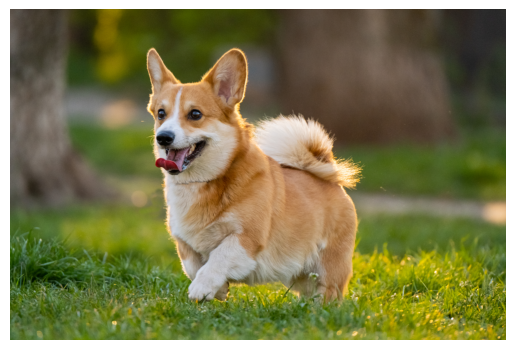

In [10]:
img = Image.open("imageVisualization/testImage.png")
# img = Image.open("imageVisualization/img.png")
# img = Image.open("imageVisualization/img3.png")


npArray = np.array(img)
plt.imshow(img)
plt.axis('off')

In [11]:
tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [12]:
print(npArray.shape)
tensorFrames = tranform(img)
print(tensorFrames.shape)
tensorFrames = tensorFrames/255.0
tensorFrames.shape

(4029, 6044, 3)
torch.Size([3, 128, 128])


torch.Size([3, 128, 128])

In [13]:
BATCH_SIZE = 2
codeBookdim = 1024
embedDim = 256
hiddenDim = 512
inChannels = 3
tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelA = VecQVAE(inChannels=3, hiddenDim=512, codeBookdim=1024, embedDim=256).to(device)
# modelA = torch.nn.DataParallel(modelA)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.1284451e-25..1.0205021].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.3143066e-27..1.0570015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.9727005e-26..1.028636].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.205134e-27..1.0382988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.4152293e-27..1.0446205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.2270155e-28..1.0410132].


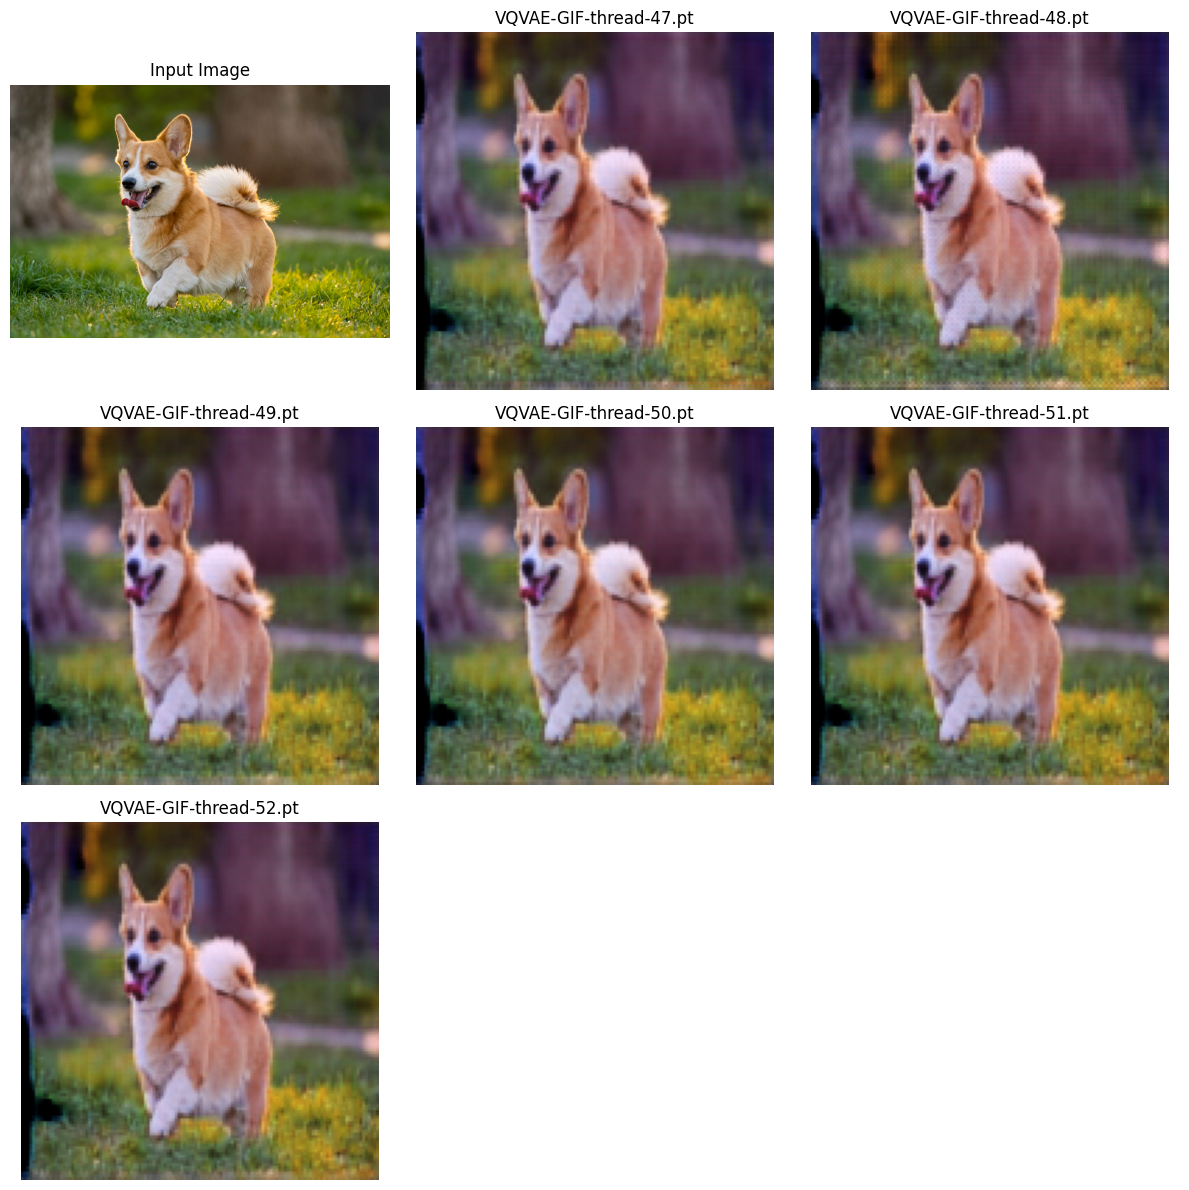

In [14]:
modelDir = "/Users/ishananand/Desktop/Text-To-Video-Generation/models"
dir =  sorted(os.listdir(modelDir))
decoded_images = []
names = []

decoded_images.append(npArray)
names.append("Input Image")
for i in range(len(dir)):
    if dir[i] != ".DS_Store":
        names.append(dir[i])
        modelValA = torch.load(modelDir + "/" +dir[i], map_location=torch.device('cpu'))
        # print(modelDir + "/" +dir[i])
        modelA.load_state_dict(modelValA['model_state_dict'])

        with torch.inference_mode():
            encodedImage, skips = modelA.encodeImage(tensorFrames.unsqueeze(0), )
            # print(encodedImage.shape)
            decodedImage = modelA.decodeImage(encodedImage, skips)

        decodedImage = rearrange(decodedImage, 'b c h w -> b h w c')
        npImage = (decodedImage * 255.0).squeeze().squeeze().detach().numpy()
        decoded_images.append(npImage)

num_images = len(decoded_images)
cols = int(np.ceil(np.sqrt(num_images)))
rows = int(np.ceil(num_images / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for idx, img in enumerate(decoded_images):
    ax = axes.flat[idx]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(names[idx])

for j in range(len(decoded_images), rows * cols):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()


In [8]:
p = []
a = torch.tensor(np.array([1,2,3,4,5]))
p.append(a)
a = torch.tensor(np.array([1,2,3,4,5]))
p.append(a)

p = torch.stack(p, dim=0)
p.shape

torch.Size([2, 5])

In [10]:
fallback = torch.zeros((256, 256, 3))
encodedImage, carry = modelA.encodeImage(tensorFrames.unsqueeze(0))
print(encodedImage.shape)

last_frame = encodedImage[-1:]               
last_frame = last_frame.repeat(20, 1, 1, 1)
print(encodedImage.shape, last_frame.shape)
images = torch.concat([encodedImage, last_frame], dim=0)
images.shape

torch.Size([1, 256, 32, 32])
torch.Size([1, 256, 32, 32]) torch.Size([20, 256, 32, 32])


torch.Size([21, 256, 32, 32])

In [1]:
CACHEDIR = "data/cacheGIF"

In [2]:
class FrameDataset(Dataset):
    def __init__(self, data, totalSequence=40, transform=None, cache_dir=CACHEDIR):
        super().__init__()
        self.data = data
        self.transform = transform
        self.totalSequence = totalSequence
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def __len__(self):
        return len(self.data)

    def npArray(self, index):
        row = self.data.iloc[index]
        url = row['url']
        resp = urllib.request.urlopen(url)
        image_data = resp.read()
        img = Image.open(io.BytesIO(image_data))

        frames = []
        for frame in ImageSequence.Iterator(img):
            frame_rgb = frame.convert("RGB")
            frames.append(np.array(frame_rgb))
        return frames

    def __getitem__(self, index):
        row = self.data.iloc[index]
        url = row['url']
        caption = row['caption']
        totalframes = row['frames']
        gif_path = os.path.join(self.cache_dir, f'{index}.gif')

        if not os.path.exists(gif_path):
            resp = urllib.request.urlopen(url)
            image_data = resp.read()
            with open(gif_path, 'wb') as f:
                f.write(image_data)
        else:
            with open(gif_path, 'rb') as f:
                image_data = f.read()

        img = Image.open(io.BytesIO(image_data))

        frames = []
        for frame in ImageSequence.Iterator(img):
            frame_rgb = frame.convert("RGB")
            frames.append(np.array(frame_rgb))

        if len(frames) < self.totalSequence:
            frames += [frames[-1]] * (self.totalSequence - len(frames))
        else:
            frames = frames[:self.totalSequence]

        if self.transform:
            tensorFrames = torch.stack([
                self.transform(Image.fromarray(frame)) for frame in frames
            ])
            tensorFrames = tensorFrames / 255.0
            return tensorFrames, caption
        else:
            return frames, caption

    
tranform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


NameError: name 'Dataset' is not defined

In [16]:
class FrameDataset(Dataset):
    def __init__(self, data, totalSequence = 40, transform = None):
        super().__init__()
        self.data = data
        self.transform = transform
        self.totalSequence = totalSequence

    def __len__(self):
        return len(self.data)
    
    def npArray(self, index):
        try:
            row = self.data.iloc[index]
            totalframes = self.data.iloc[index]['frames']
            url = row['url']
            resp = urllib.request.urlopen(url)
            image_data = resp.read()
            img = Image.open(io.BytesIO(image_data))
    
            frames = []
            for frame in ImageSequence.Iterator(img):
                frame_rgb = frame.convert("RGB")
                frames.append(np.array(frame_rgb))
    
            return frames
    
        except Exception as e:
            print(f"Error processing index {index}: {e}")
            fallback = torch.zeros((256, 256, 3), dtype=torch.uint8)
            return [fallback.numpy()]
    
    def __getitem__(self, index):
        # print(index)
        gif = self.npArray(index)
        caption = self.data.iloc[index]['caption']
        totalframes = len(gif)#self.data.iloc[index]['frames']
        
        if totalframes < self.totalSequence:
            gif += [gif[-1]] * (self.totalSequence - totalframes)

        tensorFrames = torch.stack([
            self.transform(Image.fromarray(frame)) for frame in gif
        ])

        tensorFrames = tensorFrames/255.0

        return tensorFrames, caption
    

tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

fdata = FrameDataset(dataset, transform=tranform)

X, Y = fdata.__getitem__(1)
print(X.shape, Y)

torch.Size([40, 3, 128, 128]) a man dressed in red is dancing.


In [19]:
rad = torch.randn(40, 3, 128, 128)
out, _ = modelA.encodeImage(rad)
out.shape

torch.Size([40, 256, 32, 32])

In [18]:
class Text2Video(nn.Module):
    def __init__(self, embedDimension, sequenceLength, codeBookDim, hiddenLayers, heads, feedForwardDim, text_max_length=128, drop=0.15):
        super().__init__()
        self.max_length = text_max_length
        self.embedDimension = embedDimension
        self.codeBookDim = codeBookDim
        self.sequenceLength = sequenceLength

        self.berTokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.bertModel = BertModel.from_pretrained("bert-base-uncased")
        
        for param in self.bertModel.parameters():
            param.requires_grad = False
            
        self.hiddenSize = self.bertModel.config.hidden_size
        
        self.textProjection = nn.Linear(self.hiddenSize, embedDimension)
        self.positionalEmbedding = nn.Embedding(self.max_length, embedDimension)
        self.temporalPositionalEmbedding = nn.Embedding(self.sequenceLength, embedDimension)

        self.textMultiAttention = nn.MultiheadAttention(embedDimension, heads, dropout=drop, batch_first=True)
        self.textlayerNorm = nn.LayerNorm(embedDimension)

        self.decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedDimension, 
            nhead=heads, 
            dim_feedforward=feedForwardDim, 
            dropout=drop, 
            batch_first=True,
            activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(decoder_layer=self.decoder_layer, num_layers=hiddenLayers)
        self.decoder_norm = nn.LayerNorm(embedDimension)
        
        self.frameProjection = nn.Sequential(
            nn.Linear(embedDimension, embedDimension * 2),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(embedDimension * 2, embedDimension * 8 * 8),
        )
        
        self.convolutionLayer = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(embedDimension, embedDimension, kernel_size=4, stride=2, padding=1),
                nn.GroupNorm(min(32, embedDimension//8), embedDimension),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.ConvTranspose2d(embedDimension, embedDimension, kernel_size=4, stride=2, padding=1),
                nn.GroupNorm(min(32, embedDimension//8), embedDimension),
                nn.GELU(),
            )
        ])
        
        self.outputLayer = nn.Conv2d(embedDimension, embedDimension, kernel_size=3, padding=1)

    def forward(self, text, device):
        if isinstance(text, str):
            text = [text]
        elif isinstance(text, (list, tuple)):
            pass
        else:
            raise ValueError(f"Give string or list of strings, recieved this {type(text)}")
            
        batchSize = len(text)

        tokens = self.berTokenizer(text, return_tensors='pt', padding='max_length', 
                                  truncation=True, max_length=self.max_length).to(device)
        with torch.no_grad():
            outputs = self.bertModel(**tokens)
            lastLayerEMbeddings = outputs.last_hidden_state
        
        positions = torch.arange(0, self.max_length, device=lastLayerEMbeddings.device).unsqueeze(0).expand(batchSize, -1)
        positionalEmbeddings = self.positionalEmbedding(positions)
        
        textEmbeddings = self.textProjection(lastLayerEMbeddings)
        textEmbeddings = textEmbeddings + positionalEmbeddings
        textEmbeddings = self.textlayerNorm(textEmbeddings)
        
        temporalPositions = torch.arange(0, self.sequenceLength, device=device).unsqueeze(0).expand(batchSize, -1)
        temporal_queries = self.temporalPositionalEmbedding(temporalPositions)
        
        frame_text_features, _ = self.textMultiAttention(
            query=temporal_queries,
            key=textEmbeddings,
            value=textEmbeddings
        )
        
        causal_mask = torch.triu(torch.ones(self.sequenceLength, self.sequenceLength, device=device), diagonal=1).bool()
        
        decoderOut = self.decoder(
            tgt=frame_text_features, 
            memory=textEmbeddings, 
            tgt_mask=causal_mask
        )
        decoderOut = self.decoder_norm(decoderOut)
        
        projectionLayer = self.frameProjection(decoderOut)
        projectionLayer = projectionLayer.view(batchSize * self.sequenceLength, self.embedDimension, 8, 8)
        
        allFrames = projectionLayer
        for upsample_layer in self.convolutionLayer:
            allFrames = upsample_layer(allFrames)
        
        allFrames = self.outputLayer(allFrames)
        frameEncodings = allFrames.view(batchSize, self.sequenceLength, self.embedDimension, self.codeBookDim)
        return frameEncodings
    
t2v = Text2Video(embedDimension=256, sequenceLength=40, codeBookDim=1024, hiddenLayers=6, heads=8, feedForwardDim=2048, drop=0.15)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t2v.to(device)

text = ["a cat jumping on a bed", "A man Walking", "He is Running"]

logits = t2v(text, device)
logits.shape

torch.Size([3, 40, 256, 1024])

In [87]:
32*32

1024